## GAAIMS: Predicting Multiple Sclerosis from Dynamics of Gait Variability Using an Instrumented Treadmill - A Machine Learning-Based Approach
## Butterfly Diagram
### Rachneet Kaur

### Package imports 

In [2]:
import pandas as pd
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [458]:
path = 'E:\\VR\\IEEE EMBS NER 2019 SF\\sample_data\\data_export\\'

In [459]:
# Get all the file names in the dictionary
control_ids = list(range(200, 220))
ms_ids = list(range(300, 315)) + [318, 320, 321, 322, 323]
raw_controls_t1 = [path +str(i)+ '_B3_TRIAL01_RAWDATA.csv' for i in control_ids]
raw_controls_t2 = [path +str(i)+ '_B3_TRIAL02_RAWDATA.csv' for i in control_ids]

raw_ms_t1 = [path +str(i)+ '_B3_TRIAL01_RAWDATA.csv' for i in ms_ids]
raw_ms_t2 = [path +str(i)+ '_B3_TRIAL02_RAWDATA.csv' for i in ms_ids]

gait_controls_t1 = [path +str(i)+ '_B3_TRIAL01_GAITCYCLES.csv' for i in control_ids]
gait_controls_t2 = [path +str(i)+ '_B3_TRIAL02_GAITCYCLES.csv' for i in control_ids]

gait_ms_t1 = [path +str(i)+ '_B3_TRIAL01_GAITCYCLES.csv' for i in ms_ids]
gait_ms_t2 = [path +str(i)+ '_B3_TRIAL02_GAITCYCLES.csv' for i in ms_ids]

In [460]:
# for every GaitCycle file, a sequence of walk will always start with a heel strike on the right foot.
# Thus the order of the Gait event points would be HSR, TOL, MidSSR, HSL, TOR and MidSSL.
gait_type = np.array(['HSR', 'TOL', 'MidSSR', 'HSL', 'TOR', 'MidSSL'])

### Utility functions

In [461]:
#functions to drop missing values and invalid data 
def drop_unnamed(dataframe):
    return(dataframe.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1))

#Eliminate missing values
def drop_na(dataframe):
    return(pd.DataFrame.dropna(dataframe))

#Eliminate invalid data 
def get_valid(dataframe):
    return(dataframe.loc[dataframe.Valid == True, :])

# Valid strides in the gait_cycles.csv file 
def get_cycle(dataframe):
    stride_start = min(dataframe.loc[dataframe.EventType == 'HSR'].index)
    stride_end = max(dataframe.loc[dataframe.EventType == 'MidSSL'].index)   
    return dataframe.loc[stride_start:stride_end]

# Restore the indexing for the cropped dataframe 
def change_index(dataframe):
    dataframe.index = range(len(dataframe))
    return dataframe

# get all the valid index in order: HSR-TOL-MidSSR-HSL-TOR-MidSSL
def set_complete(data_frame):
    # input is the Dataframe includes ONLY valid points 
    # get all the index of HSR since it starts with heal strike left
    # if the length of last gait cycle contain HSR does not equals to 6, then ignore it
    
    HSR = data_frame.loc[data_frame.EventType == 'HSR'].index
    last_idx = HSR[-1]
    last_all_idx = data_frame.index[-1]
    # if the last gait cycles contains HSR is not a valid gait cycle, then we should consider the last second HSR instead.
    if((last_all_idx-last_idx) < 5):
        HSR = HSR[0:-1] 
    else:
        HSR = HSR
    
    # get all the valid index in order: HSR-TOL-MidSSR-HSL-TOR-MidSSL
    valid = []
    for idx_HSR in HSR:
        if (((idx_HSR + 1) in data_frame.index) & ((idx_HSR + 2) in data_frame.index) &
            ((idx_HSR + 3) in data_frame.index) & ((idx_HSR + 4) in data_frame.index) & 
            ((idx_HSR + 5) in data_frame.index)):
            # the valid index exist in the dataframe.
            if((data_frame.loc[idx_HSR + 1].EventType == 'TOL') & (data_frame.loc[idx_HSR + 2].EventType == 'MidSSR') & 
               (data_frame.loc[idx_HSR + 3].EventType == 'HSL') & (data_frame.loc[idx_HSR + 4].EventType == 'TOR') & 
               (data_frame.loc[idx_HSR + 5].EventType == 'MidSSL')):
                valid.extend(range(idx_HSR, idx_HSR+6))
    #returns the list of valid indices which form complete strides 
    return valid

### Data preprocessing

In [462]:
#Preprocessing the files to delete missing and invalid data 
#For each person (control and MS) in Trial 1
def cleaning(pid, trial = 1, cohort = 'controls'):
    if (cohort == 'controls'):
        if (trial == 1):
            gait = pd.read_csv(gait_controls_t1[pid])
            raw = pd.read_csv(raw_controls_t1[pid])
        else:
            gait = pd.read_csv(gait_controls_t2[pid])
            raw = pd.read_csv(raw_controls_t2[pid])            
    
    if (cohort == 'pwms'):
        if (trial == 1):
            gait = pd.read_csv(gait_ms_t1[pid])
            raw = pd.read_csv(raw_ms_t1[pid])
        else:
            gait = pd.read_csv(gait_ms_t2[pid])
            raw = pd.read_csv(raw_ms_t2[pid])            
    gait = drop_na(gait)
    gait  = get_valid(gait)

    #Reducing to complete strides data 
    gait = get_cycle(gait)
    indices_complete = set_complete(gait)
    gait = gait.loc[indices_complete]

    #Resetting the index 
    gait = change_index(gait)
    return gait, raw

In [1049]:
"""
Reference: https://github.com/sukhbinder/intersection/blob/master/intersection.py
Sukhbinder
5 April 2017
"""

def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    '''
    INTERSECTIONS Intersections of curves.
       Computes the (x,y) locations where two curves intersect.  The curves
       can be broken with NaNs or have vertical segments.
    usage:
    x,y=intersection(x1,y1,x2,y2)
    '''
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

### Generating butterfly diagrams 

In [1206]:
#For generating the butterfly diagrams for Controls, PwMS Trial W and Trial WT
def butterfly_plots(pid, trial_id, cohort):
    gait, raw = cleaning(pid, trial_id, cohort)

    #For the four events of interest for butterfly diagram, computing the times from GAITCYCLES.csv file
    # HSR-TOL-MidSSR-HSL-TOR-MidSSL
    #Line 1 is COPs from HSR-TOL, Line 2 is COPs from HSL-TOR
    #gait = gait[(gait['Time']>30) & (gait['Time']<60)] 
    #Taking only 30-60 seconds of the trial for cleaner results for mean trajectory 
    stride_count = int(gait.shape[0]/6) #6 events in each stride

    HSR_times = gait['Time'][gait.EventType == 'HSR']
    HSL_times = gait['Time'][gait.EventType == 'HSL']
    TOR_times = gait['Time'][gait.EventType == 'TOR']
    TOL_times = gait['Time'][gait.EventType == 'TOL']
    
    #Taking only 30-60 seconds of the trial for cleaner results for mean trajectory     
    stride_start_index_clean = np.where(HSR_times>30)[0][0]
    stride_stop_index_clean = np.where(HSR_times<60)[0][-1]
    
    #For four events of interest, calculate the closest times from RAWDATA.csv file 
    #Closest to TOL times in raw data 
    HSR_times_raw = [raw['Time'][raw['Time']>HSR_times.iloc[i]].iloc[0] for i in range(stride_count)]
    HSL_times_raw = [raw['Time'][raw['Time']>HSL_times.iloc[i]].iloc[0] for i in range(stride_count)]
    TOR_times_raw = [raw['Time'][raw['Time']>TOR_times.iloc[i]].iloc[0] for i in range(stride_count)]
    TOL_times_raw = [raw['Time'][raw['Time']>TOL_times.iloc[i]].iloc[0] for i in range(stride_count)]
    
    #For each stride in current person-current trial 
    #HSR-TOL-MidSSR-HSL-TOR-MidSSL
    #plt.figure(figsize = (6,9))
    line1s_x, line1s_y = [], []
    line2s_x, line2s_y = [], []
    line3s_x, line3s_y = [], []
    line4s_x, line4s_y= [], []
    IPs_x, IPs_y = [], [] #Intersection points (x, y) for each stride 

    #for idx in range(stride_start_index_clean, stride_stop_index_clean): #Stride index for each person-each trial #use for mean
    for idx in range(0, stride_count): #Use for all strides 
        try:
            stride_idx = (raw['Time']>=HSR_times_raw[idx]) & (raw['Time']<HSR_times_raw[idx+1])
            COP1_idx = (raw['Time']>=HSR_times_raw[idx]) & (raw['Time']<TOL_times_raw[idx])
            line1 = raw[['COPX', 'COPY']][COP1_idx] - raw[['COPX', 'COPY']][stride_idx].mean()
            line1s_x.append(list(line1['COPX'].values))
            line1s_y.append(list(line1['COPY'].values))

            COP2_idx = (raw['Time']>=HSL_times_raw[idx]) & (raw['Time']<TOR_times_raw[idx])
            line2 = raw[['COPX', 'COPY']][COP2_idx] - raw[['COPX', 'COPY']][stride_idx].mean()
            line2s_x.append(list(line2['COPX'].values))
            line2s_y.append(list(line2['COPY'].values))

            COP3_idx = (raw['Time']>=TOL_times_raw[idx]) & (raw['Time']<HSL_times_raw[idx])
            line3 = raw[['COPX', 'COPY']][COP3_idx] - raw[['COPX', 'COPY']][stride_idx].mean()
            line3s_x.append(list(line3['COPX'].values))
            line3s_y.append(list(line3['COPY'].values))

            COP4_idx = (raw['Time']>=TOR_times_raw[idx]) & (raw['Time']<HSR_times_raw[idx+1])
            line4 = raw[['COPX', 'COPY']][COP4_idx] - raw[['COPX', 'COPY']][stride_idx].mean()
            line4s_x.append(list(line4['COPX'].values))
            line4s_y.append(list(line4['COPY'].values))

        
            IP_x, IP_y = intersection(line1['COPX'].values, line1['COPY'].values, line2['COPX'].values, line2['COPY'].values)
            IPs_x.append(IP_x)
            IPs_y.append(IP_y)
            
            '''
            #Plotting for each stride 
            plt.plot(line1.iloc[:,0].values, line1.iloc[:, 1].values, 'c-', alpha = 0.4)
            plt.plot(line2.iloc[:,0].values, line2.iloc[:, 1].values, 'c-', alpha = 0.4)
            plt.plot(line3.iloc[:,0].values, line3.iloc[:, 1].values, 'c-', alpha = 0.4)
            plt.plot(line4.iloc[:,0].values, line4.iloc[:, 1].values, 'c-', alpha = 0.4)
            #plt.plot(IP_x, IP_y, 'yo')
            '''
        except: #For the last stride when HSR of next stride is unavailable 
            continue 
    '''
    #For plotting the clean mean trajectory, we use normalization w.r.t time 
    line1_mean = np.array([pd.DataFrame(line1s_x).iloc[:, :301].interpolate(method='linear', limit_direction='forward', axis=1).mean(), 
                           pd.DataFrame(line1s_y).iloc[:, :301].interpolate(method='linear', limit_direction='forward', axis=1).mean()])
    line2_mean = np.array([pd.DataFrame(line2s_x).iloc[:, :271].interpolate(method='linear', limit_direction='forward', axis=1).mean(), 
                           pd.DataFrame(line2s_y).iloc[:, :271].interpolate(method='linear', limit_direction='forward', axis=1).mean()])
    line3_mean = np.array([pd.DataFrame(line3s_x).iloc[:, :231].interpolate(method='linear', limit_direction='forward', axis=1).mean(), 
                           pd.DataFrame(line3s_y).iloc[:, :231].interpolate(method='linear', limit_direction='forward', axis=1).mean()])
    line4_mean = np.array([pd.DataFrame(line4s_x).iloc[:, :211].interpolate(method='linear', limit_direction='forward', axis=1).mean(), 
                       pd.DataFrame(line4s_y).iloc[:, :211].interpolate(method='linear', limit_direction='forward', axis=1).mean()])
    plt.plot(line1_mean[0], line1_mean[1], 'k-', linewidth=4, label = None)
    plt.plot(line2_mean[0], line2_mean[1], 'k-', linewidth=4, label = None)
    plt.plot(line3_mean[0], line3_mean[1], 'k-', linewidth=4, label = None)
    plt.plot(line4_mean[0], line4_mean[1], 'k-', linewidth=4, label = 'average trajectory')    
    plt.plot(np.mean(pd.DataFrame(IPs_x))[0], np.mean(pd.DataFrame(IPs_y))[0], 'gd')
    plt.xlim((-0.25,0.25))
    plt.ylim((-0.5, 0.5))
    #plt.xlabel('Position of center of pressure in x-direction')
    #plt.ylabel('Position of center of pressure in y-direction')
    #plt.title('Butterfly diagram: PwMS ID ' + str(pid+1) + ', Trial Walking & Talking (WT)')
    #plt.savefig(path + '..\\butterfly\\' + 'pwms'+str(pid+1)+'_trial'+str(trial_id)+'.jpg')
    plt.legend()
    plt.show()
    '''
    
    return IPs_x, IPs_y

### Computing the intersection points 

In [1233]:
#One with PatientID, TrialID, Mean(x), Mean(y), SD(x), SD(y)
df1 = pd.DataFrame()
#Another with Patient ID, Trial ID, x, y, (x-mean(x))^2, (y-mean(y))^2
df2 = pd.DataFrame()

cohorts = ['controls', 'pwms']
trials = [1, 2]
for trial_id in trials:
    for cohort in cohorts:
        for index in range(0, 20): #20 people in each cohort and each trial
            if cohort == 'controls':
                pid = control_ids[index]
            else:
                pid = ms_ids[index]
            IPs_x, IPs_y = butterfly_plots(index, trial_id, cohort)
            
            IPs_x = pd.DataFrame(IPs_x)[0]
            IPs_y = pd.DataFrame(IPs_y)[0]
            #Append NaN at the end to compensate for last stride not computed 
            IPs_x  = IPs_x.append(pd.Series([np.nan]), ignore_index = True)
            IPs_y = IPs_y.append(pd.Series([np.nan]), ignore_index = True)
            IPs_x_abs = IPs_x.abs()
            IPs_y_abs = IPs_y.abs()
            mean_x = IPs_x.mean()
            mean_y = IPs_y.mean()
            mean_x_abs = IPs_x_abs.mean()
            mean_y_abs = IPs_y_abs.mean()
            sd_x = IPs_x.std()
            sd_y = IPs_y.std()
            df1 = df1.append([[pid, trial_id, mean_x, mean_y, mean_x_abs, mean_y_abs, sd_x, sd_y]], ignore_index=True)
            squared_diff_x = (IPs_x- mean_x)**2
            squared_diff_y = (IPs_y- mean_y)**2
            temp_df = pd.DataFrame([[pid]*len(IPs_x), [trial_id]*len(IPs_x), list(IPs_x.values), list(IPs_y.values), 
                                    list(IPs_x_abs.values), list(IPs_y_abs.values), list(squared_diff_x.values), 
                                    list(squared_diff_y.values)]).T
            df2 = df2.append(temp_df, ignore_index= True)

df1.columns = ['PID', 'TrialID', 'ButterflyMean_x', 'ButterflyMean_y', 'ButterflyMean_x_abs', 'ButterflyMean_y_abs', 
               'ButterflySD_x', 'ButterflySD_y']
df2.columns = ['PID', 'TrialID', 'Butterfly_x', 'Butterfly_y', 'Butterfly_x_abs', 'Butterfly_y_abs', 
               'ButterflySQ_x', 'ButterflySQ_y']

In [1235]:
#Saving 2 csvs
#One with PatientID, TrialID, Mean(x), Mean(y), SD(x), SD(y)
df1.to_csv(path+'..\\butterfly\\ButterflyMeanSD.csv')
#Another with Patient ID, Trial ID, x, y, (x-mean(x))^2, (y-mean(y))^2
df2.to_csv(path+'..\\butterfly\\ButterflyFeatures.csv')

### Correlation 

In [ ]:
#Checking correlation of butterfly parameters with labels & EDSS for PwMS

In [1290]:
df2['Label'] = [int (i) for i in df2['PID']/100>3] #Assigning 0 for Healthy, 1 for PwMS
colors = ['blue', 'red']

In [1319]:
df2[['Butterfly_x', 'Butterfly_y', 'Butterfly_x_abs', 'Butterfly_y_abs', 'ButterflySQ_x', 'ButterflySQ_y', 'Label']].corr()

,Butterfly_x,Butterfly_y,Butterfly_x_abs,Butterfly_y_abs,ButterflySQ_x,ButterflySQ_y,Label
Butterfly_x,1.000000,-0.299939,0.132696,-0.149453,-0.047323,-0.053026,0.098535
Butterfly_y,-0.299939,1.000000,-0.148859,0.176598,-0.106470,-0.374326,0.016636
Butterfly_x_abs,0.132696,-0.148859,1.000000,0.051762,0.797073,0.113043,0.124149
Butterfly_y_abs,-0.149453,0.176598,0.051762,1.000000,0.059673,0.617665,0.028079
ButterflySQ_x,-0.047323,-0.106470,0.797073,0.059673,1.000000,0.096472,0.068406
ButterflySQ_y,-0.053026,-0.374326,0.113043,0.617665,0.096472,1.000000,0.002927
Label,0.098535,0.016636,0.124149,0.028079,0.068406,0.002927,1.000000


### Visualizations

In [7]:
df2 = pd.read_csv('C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\ButterflyFeatures.csv')
df2['Label'] = [int (i) for i in df2['PID']/100>3] #Assigning 0 for Healthy, 1 for PwMS

In [8]:
#Converting the values to millimeters from meters 
df2['Butterfly_x_abs_mm']=df2['Butterfly_x_abs']*1000
df2['ButterflySQ_x_mm']=df2['ButterflySQ_x']*1000

### Boxplots and Swarmplots for Trial W and Trial WT - Lateral Shift (in x axis)

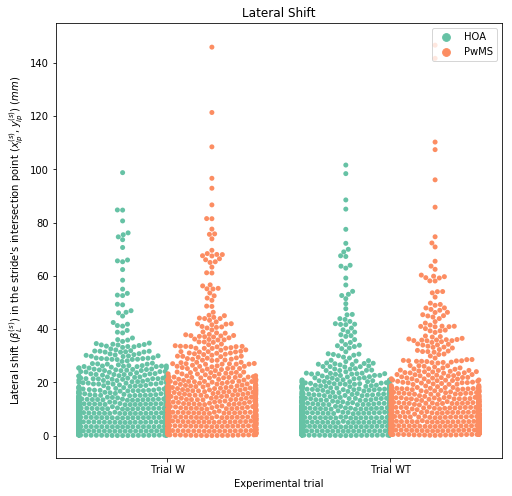

In [1488]:
#Trial W - Box plot without and with outliers  (swarmplot)
plt.figure(figsize = (8, 8))
# ax = sns.boxplot(x= 'TrialID', hue = 'Label', y='Butterfly_x_abs_mm', data=df2, linewidth=2.5, palette="Set3", 
#                  width=0.6, showfliers = False)
# ax = sns.violinplot(x= 'TrialID', hue = 'Label', y='Butterfly_x_abs_mm', data=df2, dodge = True, inner=None, split = True)
ax = sns.swarmplot(x= 'TrialID', hue = 'Label', y='Butterfly_x_abs_mm', data=df2, dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right')
plt.ylabel(r"Lateral shift ($\beta_L^{(s)}$) in the stride's intersection point $(x_{ip}^{(s)}, y_{ip}^{(s)})$ ($mm$)")
plt.xlabel('Experimental trial')
plt.xticks([0, 1], ['Trial W', 'Trial WT'])
plt.title('Lateral Shift')
# plt.savefig(path + '..\\butterfly\\boxplots\\x_abs_w_wt.png', dpi = 250) #Use Box plot here 
plt.savefig(path + '..\\butterfly\\boxplots\\x_abs_withOutliers_w_wt.png', dpi = 250) #Use Swarmplot here 
plt.show()


### Boxplots and Swarmplots for Trial W and Trial WT - Lateral Variability (in x axis)

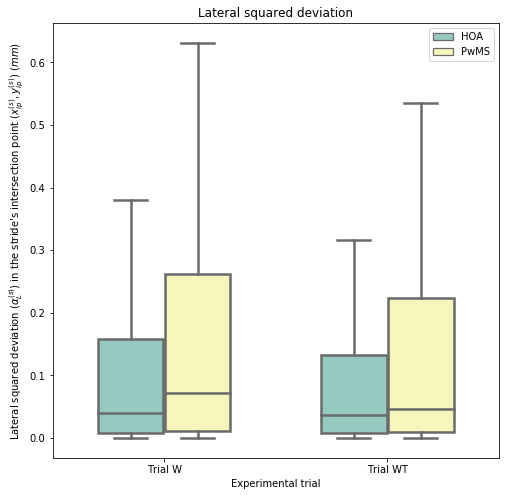

In [10]:
#Trial W - Box plot without and with outliers  (swarmplot)
plt.figure(figsize = (8, 8))
ax = sns.boxplot(x= 'TrialID', hue = 'Label', y='ButterflySQ_x_mm', data=df2, linewidth=2.5, palette="Set3", width=0.6, showfliers = False)
# ax = sns.swarmplot(x= 'TrialID', hue = 'Label', y='ButterflySQ_x_mm', data=df2, dodge = True, palette="Set2")
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['HOA', 'PwMS'], loc = 'upper right')
plt.ylabel(r"Lateral squared deviation ($\alpha_L^{(s)}$) in the stride's intersection point $(x_{ip}^{(s)}, y_{ip}^{(s)})$ ($mm$)")
plt.xlabel('Experimental trial')
plt.title('Lateral squared deviation')
plt.xticks([0, 1], ['Trial W', 'Trial WT'])
plt.savefig('C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\SQ_x_w_wt.png', dpi = 250) #Use box plot here 
# plt.savefig('C:\\Users\\Rachneet Kaur\\Dropbox\\GAIT\\SQ_x_withOutliers_w_wt.png', dpi = 250) #Use swarmplot here
plt.show()